In [1]:
import pandas as pd
import numpy as np
from scipy import spatial
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon
import fiona
import statistics
import contextily as cx
from stargazer.stargazer import Stargazer

In [2]:
mypath = '../trips/'

In [3]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [4]:
onlyfiles

['2022_09_13_LA2 Logi Jeep_08_37_08_55_4d1df21e-1df7-418c-baf9-68e3740e05c7.csv',
 '2022_09_13_LA2 Logi Jeep_09_06_09_22_41ab7e72-261b-4d62-9c98-e08ba9481c14.csv',
 '2022_09_13_LA2 Logi Jeep_09_35_09_52_45fae92d-20f9-4491-8a99-95bce6600f9a.csv',
 '2022_09_13_LA2 Logi Jeep_10_01_10_23_5a6d7011-37b3-4fc1-95a7-23aaefab1c84.csv',
 '2022_09_13_LA2 Logi Jeep_11_51_12_09_17b1d6dd-ed86-4d89-b2e0-9a84af6e8794.csv',
 '2022_09_13_LA2 Logi Jeep_12_24_12_42_ee6f89f4-a177-4115-b5d3-b44607330ad4.csv',
 '2022_09_13_PS Skylark Test_08_39_08_56_9d20e0db-2ac0-4d7a-81bc-85c27bbe99b0.csv',
 '2022_09_13_PS Skylark Test_09_09_09_23_23351042-777c-4a84-9d81-b74d77210823.csv',
 '2022_09_13_PS Skylark Test_09_39_09_52_68d2ae18-a20c-49b9-8411-ca1d19853cc7.csv',
 '2022_09_13_PS Skylark Test_10_00_10_23_378bf299-ee7d-42f2-947c-bd1e8ae97b8c.csv',
 '2022_09_13_PS Skylark Test_11_51_12_12_dc18ac87-773d-4df8-8940-6242e327d7a3.csv',
 '2022_09_13_PS Skylark Test_12_25_12_42_730f4b99-81c3-4066-bb9e-06642f6ebda6.csv',
 '20

In [5]:
def filterSubstr(lists, substr):
    return [x for x in lists if substr in x]

searchString = '2022_09_13'
onlyfiles_13_09 = filterSubstr(onlyfiles, searchString)
onlyfiles_13_09

searchString = '_10_0'
onlyfiles = filterSubstr(onlyfiles_13_09, searchString)
onlyfiles

['2022_09_13_LA2 Logi Jeep_10_01_10_23_5a6d7011-37b3-4fc1-95a7-23aaefab1c84.csv',
 '2022_09_13_PS Skylark Test_10_00_10_23_378bf299-ee7d-42f2-947c-bd1e8ae97b8c.csv',
 '2022_09_13_RW2 Logi Jeep_10_01_10_23_5678d13c-1f63-4710-999f-aa9fa553baa5.csv']

In [6]:
allfiles = []
for i in range(len(onlyfiles)):
    df = pd.read_csv(mypath + str(onlyfiles[i]), sep=';', decimal=',')
    df['Time[ms]'] = pd.to_datetime(df['Time[ms]'], unit='ms')
    df['driver'] = str(onlyfiles[i])[11:13]
    coord_ = [Point(x, y) for x, y in zip(df.Longitude, df.Latitude)]
    alldata_ = gpd.GeoDataFrame(df, geometry=coord_, crs ="EPSG:4326")
    allfiles.append(df)
alldata = pd.concat(allfiles, axis=0).reset_index(drop=True)

In [7]:
alldata['data'] = alldata['Time[ms]'].dt.date

In [8]:
alldata["data"] = pd.to_datetime(alldata["data"])

In [9]:
alldata_RW = alldata[alldata.driver == 'RW']
alldata_PS = alldata[alldata.driver == 'PS']
alldata_LA = alldata[alldata.driver == 'LA']

In [10]:
allfiles = []
for i in range(len(onlyfiles)):
    df = pd.read_csv(mypath + str(onlyfiles[i]), sep=';', decimal=',')
    df['Time[ms]'] = pd.to_datetime(df['Time[ms]'], unit='ms')
    df['driver'] = str(onlyfiles[i])[11:13]
    coord_ = [Point(x, y) for x, y in zip(df.Longitude, df.Latitude)]
    alldata_ = gpd.GeoDataFrame(df, geometry=coord_, crs ="EPSG:4326")
    allfiles.append(df)

In [11]:
alldata = pd.concat(allfiles, axis=0).reset_index(drop=True)

In [12]:
alldata.driver.unique()

array(['LA', 'PS', 'RW'], dtype=object)

In [13]:
alldata_SORTED = alldata.sort_values(by = 'Time[ms]').reset_index(drop=True)

In [14]:
alldata_SORTED_cut = alldata_SORTED.dropna().reset_index(drop=True)

In [15]:
alldata_SORTED_cut['Time'] = pd.to_datetime(alldata_SORTED_cut['Time[ms]'].dt.strftime('%H:%M:%S'))

In [16]:
rw = alldata_SORTED_cut[alldata_SORTED_cut.driver == 'RW'].reset_index(drop=True).drop_duplicates()
la = alldata_SORTED_cut[alldata_SORTED_cut.driver == 'LA'].reset_index(drop=True).drop_duplicates()
ps = alldata_SORTED_cut[alldata_SORTED_cut.driver == 'PS'].reset_index(drop=True).drop_duplicates()

In [17]:
from haversine import haversine, Unit
import haversine as hs

In [18]:
platoon_alldist = []
platoon_all_CO2 = []

platoon_all_lat_dist = []
platoon_all_lon_dist = []

platoon_all_lat_CO2 = []
platoon_all_lon_CO2 = []

#ps --> rw
#jc --> la
#dw --> ps


for i in range(len(rw)):
    platoon_lat_dist = []
    platoon_lon_dist = []
    platoon_lat_CO2 = []
    platoon_lon_CO2 = []
    platoon_dist = []
    CO2_max = []
    dist_mat = []
    
    rw_ = rw.iloc[i]
    
    df_array1 = (rw_.Latitude, rw_.Longitude)

    la_ = la[la['Time'] > rw_['Time']].reset_index(drop=True)
    df_array2 = list(zip(la_.Latitude, la_.Longitude))[0:60]
        
    for j in range(len(df_array2)):
        dist_mat.append(hs.haversine(df_array1,df_array2[j],unit=Unit.METERS))

    la_mindist = min(dist_mat)
    la_mindist_index = dist_mat.index(la_mindist)

    platoon_dist.append(la_mindist)

    platoon_lat_dist.append(la_.iloc[la_mindist_index]["Latitude"])
    platoon_lon_dist.append(la_.iloc[la_mindist_index]["Longitude"])

    CO2 = []
    CO2.append(la_.iloc[0]['CO2[kg]'])
    try:
        CO2.extend(list(la_.iloc[1:21]['CO2[kg]']))
    except:
        pass
    
    la_maxCO2 = max(CO2)
    la_maxCO2_index = CO2.index(la_maxCO2)
    CO2_max.append(la_.reset_index(drop=True).iloc[la_maxCO2_index]['CO2[kg]'])
    platoon_lat_CO2.append(la_.reset_index(drop=True).iloc[la_maxCO2_index]["Latitude"])
    platoon_lon_CO2.append(la_.reset_index(drop=True).iloc[la_maxCO2_index]["Longitude"])    


    ps_ = ps[ps['Time'] > la_['Time'][la_mindist_index]].reset_index(drop=True)
    df_array3 = list(zip(ps_.Latitude, ps_.Longitude))[0:60]        
    
    dist_mat = []

    for j in range(len(df_array3)):
        dist_mat.append(hs.haversine(df_array2[la_mindist_index],df_array3[j],unit=Unit.METERS))

    ps_mindist = min(dist_mat)
    ps_mindist_index = dist_mat.index(ps_mindist)

    platoon_dist.append(ps_mindist)
    platoon_lat_dist.append(ps_.reset_index(drop=True).iloc[ps_mindist_index]["Latitude"])
    platoon_lon_dist.append(ps_.reset_index(drop=True).iloc[ps_mindist_index]["Longitude"])    

    CO2 = []

    CO2.append(ps_.iloc[0]['CO2[kg]'])
    try:
        CO2.extend(list(ps_.iloc[1:21]['CO2[kg]']))
    except:
        pass
    ps_maxCO2 = max(CO2)
    ps_maxCO2_index = CO2.index(ps_maxCO2)
    CO2_max.append(ps_.reset_index(drop=True).iloc[ps_maxCO2_index]['CO2[kg]'])
    platoon_lat_CO2.append(ps_.reset_index(drop=True).iloc[ps_maxCO2_index]["Latitude"])
    platoon_lon_CO2.append(ps_.reset_index(drop=True).iloc[ps_maxCO2_index]["Longitude"])  

      
    platoon_all_lat_dist.append(platoon_lat_dist)
    platoon_all_lon_dist.append(platoon_lon_dist)
    platoon_all_lat_CO2.append(platoon_lat_CO2)
    platoon_all_lon_CO2.append(platoon_lon_CO2)
    platoon_alldist.append(platoon_dist)
    platoon_all_CO2.append(CO2_max)

<Axes: >

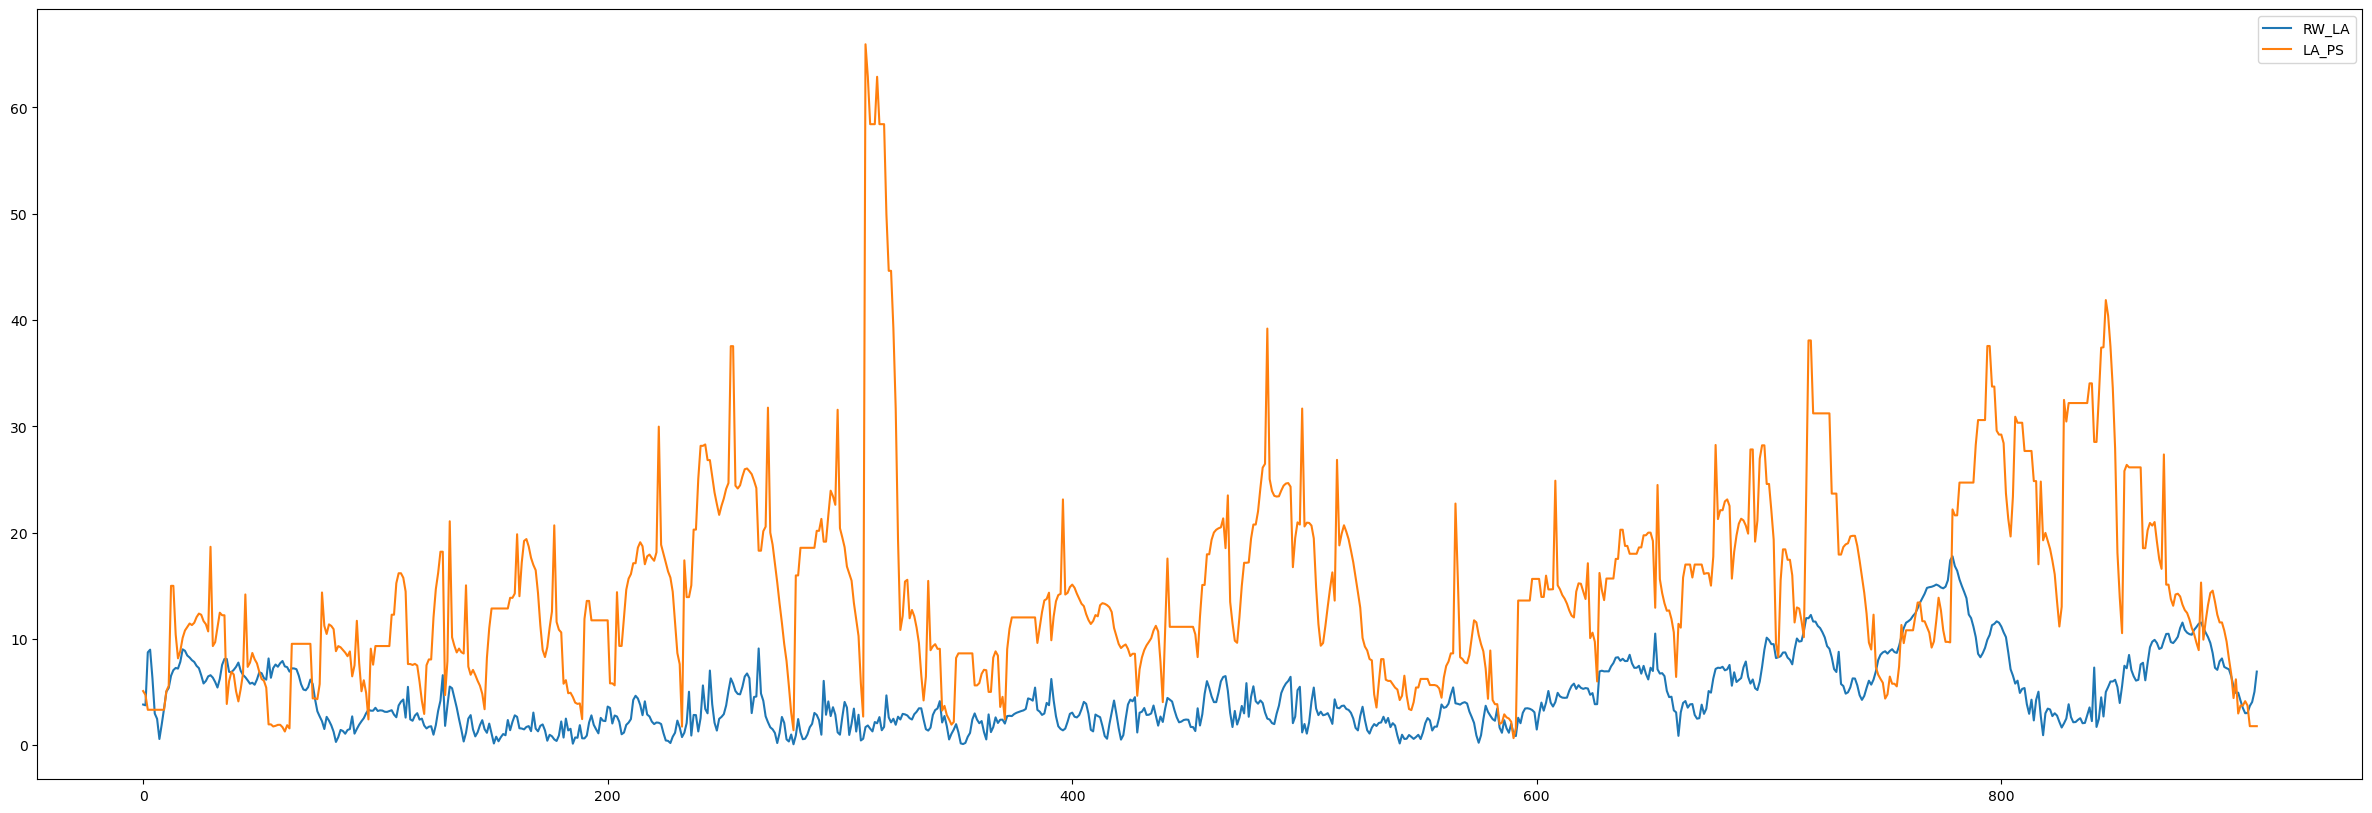

In [19]:
pd.DataFrame(platoon_alldist, columns = ['RW_LA', 'LA_PS']).plot(figsize=(30,10))

In [20]:
dist_v = pd.DataFrame(platoon_alldist, columns = ['RW_LA', 'LA_PS'])
pd.DataFrame(platoon_alldist, columns = ['RW_LA', 'LA_PS']).to_csv('distance_platoon.csv', index=False)

In [21]:
dist_coord = pd.concat([pd.DataFrame(platoon_all_lat_dist, columns=['v1_lat', 'v2_lat'])['v1_lat'], pd.DataFrame(platoon_all_lon_dist, columns=['v1_lon', 'v2_lon'])['v1_lon'],pd.DataFrame(platoon_all_lat_dist, columns=['v1_lat', 'v2_lat'])['v2_lat'], pd.DataFrame(platoon_all_lon_dist, columns=['v1_lon', 'v2_lon'])['v2_lon']], axis=1)

In [22]:
pd.concat([pd.DataFrame(platoon_all_lat_dist, columns=['v1_lat', 'v2_lat'])['v1_lat'], pd.DataFrame(platoon_all_lon_dist, columns=['v1_lon', 'v2_lon'])['v1_lon'],pd.DataFrame(platoon_all_lat_dist, columns=['v1_lat', 'v2_lat'])['v2_lat'], pd.DataFrame(platoon_all_lon_dist, columns=['v1_lon', 'v2_lon'])['v2_lon']], axis=1).to_csv('platoon_distances_coord.csv', index=False)

In [27]:
infr = pd.read_csv('../infrast_data_update_.csv', sep=';')
infr.what.unique()

array(['Turn_left', '4-ways intersection', 'Traffic_light', 'Curve',
       'Road_immission', 'Turn_right'], dtype=object)

In [28]:
allveic = []
for k in range(0, len(dist_coord.columns)-1, 2):
    veic = []
    for i in range(len(dist_coord)):
        infra = []
        for j in range(len(infr)):
            inf = (infr.iloc[j].lon,infr.iloc[j].lat)
            distcoor = (dist_coord.iloc[i][str(dist_coord.columns[k+1])], dist_coord.iloc[i][str(dist_coord.columns[k])])
            infra.append(hs.haversine(inf,distcoor,unit=Unit.METERS))
        veic.append(infra)
    allveic.append(veic)

In [29]:
v1 = pd.DataFrame(allveic[0])
v2 = pd.DataFrame(allveic[1])

In [30]:
allfeat = []
for i in range(len(v1)): 
    allfeat.append(list(v1[v1<500].iloc[i].dropna()))
new_v1 = pd.DataFrame(allfeat).iloc[:,0:7].fillna(0)

In [31]:
allfeat = []
for i in range(len(v2)): 
    allfeat.append(list(v2[v2<500].iloc[i].dropna()))
new_v2 = pd.DataFrame(allfeat).iloc[:,0:7].fillna(0)

In [32]:
v1.columns = infr.what
v2.columns = infr.what

In [33]:
vlist = []
vlist.append(v1)
vlist.append(v2)

In [34]:
import statsmodels.api as sm

In [44]:
all_X = []
all_y = []

for k in range(len(vlist)):
    feats = []
    v = vlist[k]
    infrast = v.idxmin(axis=1)
    for i in range(len(v)):
        if (v.iloc[i][str(infrast[i])] < 80).any():
            feats.append([infrast[i]])
        else:
            feats.append([])
    new_v = pd.get_dummies(pd.DataFrame(feats), prefix='Feat')

    X = new_v.copy()
    y = dist_v[str(dist_v.columns[k])]
    X['old_dist'] = dist_v[str(dist_v.columns[k])].shift(10).fillna(0)
    all_X.append(X)
    all_y.append(y)

all_X_ = pd.concat(all_X).reset_index(drop=True).fillna(0)
all_y_ = pd.concat(all_y).reset_index(drop=True).fillna(0)
model1 = sm.OLS(y, X).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  LA_PS   R-squared (uncentered):                   0.760
Model:                            OLS   Adj. R-squared (uncentered):              0.758
Method:                 Least Squares   F-statistic:                              409.1
Date:                Sun, 06 Aug 2023   Prob (F-statistic):                   4.14e-275
Time:                        08:49:34   Log-Likelihood:                         -3255.0
No. Observations:                 911   AIC:                                      6524.
Df Residuals:                     904   BIC:                                      6558.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Feat_4-ways intersection     5.2181      1.541      3.385      0.001       2.193       8.243
Feat_Curve                   5.1569      1.487      3.469      0.001       2.239       8.074
Feat_Road_immission          9.4298      1.152      8.182      0.000       7.168      11.692
Feat_Traffic_light           5.8874      0.544     10.827      0.000       4.820       6.955
Feat_Turn_left               4.3706      1.715      2.548      0.011       1.004       7.737
Feat_Turn_right              7.8947      1.399      5.645      0.000       5.150      10.640
old_dist                     0.6095      0.025     24.240      0.000       0.560       0.659
==============================================================================
Omnibus:                      206.583   Durbin-Watson:                   0.313
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1179.317
Skew:                           0.904   Prob(JB):                    8.22e-257
Kurtosis:                       8.272   Cond. No.                         107.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
results_summary = model.summary()
df = pd.DataFrame.from_records(results_summary.tables[1].data)
header = df.iloc[0]
df = df[1:] # take the data less the header row
df.columns = header
df.to_csv('platoon_II_13_09_10_01_10.csv')

In [45]:
platoon_all_CO2_ = pd.DataFrame(platoon_all_CO2, columns = ['RW_LA', 'LA_PS'])
pd.DataFrame(platoon_all_CO2, columns = ['RW_LA', 'LA_PS']).to_csv('CO2_platoon.csv', index=False)

all_X = []
all_y = []

for k in range(len(vlist)):
    feats = []
    v = vlist[k]
    infrast = v.idxmin(axis=1)
    for i in range(len(v)):
        if (v.iloc[i][str(infrast[i])] <80).any():
            feats.append([infrast[i]])
        else:
            feats.append([])
    new_v = pd.get_dummies(pd.DataFrame(feats), prefix='Feat')

    X = new_v.copy()
    y = platoon_all_CO2_[str(platoon_all_CO2_.columns[k])]
    X['old_dist'] = dist_v[str(dist_v.columns[k])].shift(10).fillna(0)
    all_X.append(X)
    all_y.append(y)

all_X_ = pd.concat(all_X).reset_index(drop=True).fillna(0)
all_y_ = pd.concat(all_y).reset_index(drop=True).fillna(0)
model2 = sm.OLS(y, X).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  LA_PS   R-squared (uncentered):                   0.558
Model:                            OLS   Adj. R-squared (uncentered):              0.554
Method:                 Least Squares   F-statistic:                              162.9
Date:                Sun, 06 Aug 2023   Prob (F-statistic):                   2.00e-155
Time:                        08:49:54   Log-Likelihood:                          3703.5
No. Observations:                 911   AIC:                                     -7393.
Df Residuals:                     904   BIC:                                     -7359.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Feat_4-ways intersection     0.0027      0.001      3.687      0.000       0.001       0.004
Feat_Curve                   0.0007      0.001      1.044      0.297      -0.001       0.002
Feat_Road_immission          0.0096      0.001     17.360      0.000       0.009       0.011
Feat_Traffic_light           0.0019      0.000      7.130      0.000       0.001       0.002
Feat_Turn_left               0.0016      0.001      1.964      0.050    1.24e-06       0.003
Feat_Turn_right              0.0036      0.001      5.287      0.000       0.002       0.005
old_dist                     0.0001   1.21e-05      9.925      0.000    9.64e-05       0.000
==============================================================================
Omnibus:                      450.411   Durbin-Watson:                   0.153
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4173.643
Skew:                           2.047   Prob(JB):                         0.00
Kurtosis:                      12.654   Cond. No.                         107.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
results_summary = model.summary()
df = pd.DataFrame.from_records(results_summary.tables[1].data)
header = df.iloc[0]
df = df[1:] # take the data less the header row
df.columns = header
df.to_csv('platoon_II_13_09_10_01_10_CO2.csv')

In [47]:
stargazer = Stargazer([model1,model2,model1,model2])
#stargazer.custom_columns(ts,[1]*len(ts))
stargazer.show_model_numbers(False)
stargazer.show_degrees_of_freedom(False)
with open('../latex/1.tex','w') as f:
    f.write(stargazer.render_latex())
stargazer